Introduction to data science with Python; Matej Guid, Oh.D., Martin Možina Ph.D.
Ljubljana, 15.4.2016

1. I will analyze Slovenian car market and try to answer some interesting questions stated below. 
2. After this section design plan of Python program is described. 
3. In the largest section source code with all comments can be found and run. 


First I will do some general data cleaning and basic statistic analysis to check the data consistency:
1. Outliers and missing data
- I will remove all sets, that has missing any kind of numerical values (e.g. mileage, year of car, price) and will leave those sets with missing non-numerical values (e.g. engine type and gearbox) except brand/model names. 
- I will check for outliers graphicaly for numerical fields.

2. Normality distribution, Skewness, Kurtosis, Homoscedascity, Kolmogorov Smirnov test, 

Then I will try answer next questions:
1. Number of all cars found for choosen brand and number of usefull data - without missing data
2. Number of different models

3. Biggest price range for each model (for all years and for each year separately)
4. Smallest price range for each model (for all years and for each year separately)

5. Price (drop) change for a choosen model through years
6. Price (drop) change for a choosen model compared to milage

7. Price (drop) change difference for two models through years

8. Lets see those cars who did not do more than 1.000km per year - 'suspicious cars'
__________
9. How high is the owner loyalty of car model in years?

10. Show year that has biggest price difference for chosen model 

11. Show how on choosen model milage affects price for chosen year and in which year the difference is the  biggest. Which model price is most affected by milage and age respectively.
 
12. In which 3 year period two of compared models looses less value ?

Do all the statistics for two models
1. Compare price change in first 3 years for comparable model absolute number and percentage
2. How is price dropping and from which point in time on is the price of two different model the same ?
3. In which point in time have two different models of the same brand similar price (e.g. Audi A6 new is 50.000 EUR, A3 new is 30.000 EUR, but after n years the differenc is smaller than diff) ?

At the end I will do multiple linear regression and try to answer the question is there any connection between age and milage predicting the price (multiple linear regression) ?



Program high level design
1. I will scratch data for chosen brand from internet web site www.avto.net and create dictionary
2. I will save all the data from dictionary to DataFrame
3. For later use I will store also all the data to csv file called "brand"
4. The data that can be acquired from web site is: 1. car brand and model, 2.car price, 3.car year of first registration, 4. car milage, 5.car engine type and 6. car gearbox type
5. The model will be derived from brand model description and calculated into new key
6. The analysis is done for two models in one brand

We do the statistics and analysis on the data.

In next part of program we will build a dataset of all positive and negative tweets for chosen car model1 and car model2.

We do the statistics and analysis on the data.

In [349]:
import requests
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
%matplotlib inline
import tweepy # we will need this for Tweeter sentiments about brand/model
consumer_key = 'tM9Gvr1Jl33VnP5nblKnnNgF1' #needed for Tweeter and is time limited
consumer_secret = 'IFKLBm0TxpnfXVZoduM3znt3Cs8T2RJ1EGcItNhebcUizfCTeJ'  #needed for Tweeter and is time limited
import numpy as np
#for linear regression we need:
from scipy import linspace, polyval, polyfit, sqrt, stats, randn
from pylab import *

In [350]:
#build function to scrap all result - go through all pages
def get_page(page_no):
    r = requests.get(url+str(page_no))
    from bs4 import BeautifulSoup
    s = BeautifulSoup(r.text, 'lxml')
    return s

In [351]:
#calculate number of all pages of all results - 48 hits per page
def get_no_pages(url):
    st=1 #initiate counter to at least one result
    p = 1 #initiate number of pages to at least one
    r = requests.get(url)
    from bs4 import BeautifulSoup
    a = BeautifulSoup(r.text, 'lxml')
    bla = a.find_all('div', {'class': 'ResultsMenuBox'})
    for b in bla:
        if st > 1:
            break
        name = b.find_all('span', {'class': 'stevec'})
        for n in name:
          st += int(n.text.strip('(,)'))
    if st > 48:
        p = st // 48
    return p #return number of pages

In [352]:
#main program

In [353]:
#define some global variables needed and initialize them
cars = [] #list of parameters for one car
cars_dict = {'BrandName':[],
             'Price':[],
             'CarAge':[],
             'Milage':[],
             'Engine':[],
             'GearBox':[]} #dictionary of all cars of one brand found in results
next_p = 1 #counter of all pages

In [354]:
brand = 'Audi' #name of searched brand on avto.net
ModelName = 'A3' #define model name needed for analyses
ModelToCompare = 'A6' #we use second model for doing some analysis comparing model 1 to model 2 (such as price drop for first 5 years)

In [355]:
#define initial - main page to scrap from
url_mobile ="http://suchen.mobile.de/fahrzeuge/auto?isSearchRequest=true&vc=Car&dam=0&ms=1900%3B"
url = 'http://www.avto.net/_AVTO/results.asp?znamka=' + brand + '&tip=katerikoli%20tip&tip2=katerikoli%20tip&znamka3=&model3=&tip3=katerikoli%20tip&cenaMin=0&cenaMax=999999&brezcene=1&letnikMin=0&letnikMax=2090&bencin=0&zavore=&pogon=&klima=&servo=&lastnik=&servis=&automatic=0&starost2=999&star1=1&star2=1&star3=&star4=1&oblika=0&ccmMin=0&ccmMax=99999&kmMin=0&kmMax=999999&kwMin=0&kwMax=999&stran='

In [356]:
#read url in variable r
r = requests.get(url)

In [357]:
#calculate how many pages of results for searched brand
all_pages = get_no_pages(url)

In [358]:
#main loop

In [359]:
while next_p <= all_pages:
  soup = get_page(next_p)
  div = soup.find_all('div', {'class' : 'ResultsAd'}) #search for main data block in html file
  for d in div:
    name = d.find('span')
    if name.text == "oldtimer" or name.text == "vozilo je v okvari": #in special cases when oldtimers are searched, structure of HTML file changes
        name = d.find_all_next('span')
        name = name[1]
    cars.append(name.text)
    cars_dict['BrandName'].append(name.text)
    ul = d.find_all('ul')
    price = d.find('div', {'class' : 'ResultsAdPrice'})
    price = str(price.text.strip('\r')) #there is some make-up noise around price that we have to take care of
    price = str(price.strip('\n'))
    price = str(price.strip(' '))
    price = str(price.strip('\t'))
    price = str(price.strip('\n'))
    price = str(price.strip('\r'))
    price = str(price.strip(' '))
    cars.append(price)
    #remove , and . from price
    price = price.replace('.', '')
    try:
      price = int(price) #try to convert from string to int
    except:
        price = float('NaN') #if price is not convertible insert NaN (it is probably text saying "pokličite za ceno")
    cars_dict['Price'].append(price)
    for u in ul:
      li = u.find_all('li')
      if len(li) != 4: #sometimes there are missing values eg. no kilometers entered
          cars = [float('NaN'),float('NaN'),float('NaN'),float('NaN'),float('NaN'),float('NaN')]
          cars_dict['CarAge'].append(cars[2])
          cars_dict['Milage'].append(cars[3])
          cars_dict['Engine'].append(cars[4])
          cars_dict['GearBox'].append(cars[5])
          cars = []  # empty list
          break

      for l in li:
          cars.append(l.text)

      cars[2] = cars[2][22:] #strip does not work correctly so I removed the characters before the year of first registration
      try:
          cars[2] = int(cars[2])
      except:
          cars[2] = float('NaN')

      cars_dict['CarAge'].append(cars[2])

      cars[3] = cars[3].strip('km').rstrip()
      try:
          cars[3] = int(cars[3])
      except:
          cars[3] = float('NaN')
      cars_dict['Milage'].append(int(cars[3]))

      cars_dict['Engine'].append(cars[4])
      cars_dict['GearBox'].append(cars[5])
      cars = [] #empty list

  next_p+=1


In [360]:
#now we have all the results in dictionary

In [361]:
#we would like to create dataframe for further data manipulation
pd.set_option('float_format', '{:0.0f}'.format)
df = pd.DataFrame(data=cars_dict,index=None)

In [362]:
#lets first extract car model from brand data (first column) and create new column named Model
df['Model'] = df['BrandName'] #copy brand name column to newly created model column
df['Model'] = df['Model'].str[len(brand):] #delete brand out of model column
df['BrandName'] = df['BrandName'].str[:len(brand)] #delete all but brand name
df

,BrandName,CarAge,Engine,GearBox,Milage,Price,Model
0,Audi,2008,"diesel motor, 2698 ccm, 132 kW / 180 KM",avtomatski menjalnik,324000,nan,A6 2.7 TDI 180ks AUTOMATIC tempomat...
1,Audi,2013,"diesel motor, 1968 ccm, 110 kW / 150 KM",avtomatski menjalnik,147500,nan,A4 Avant 2.0 TDI Business Multitron...
2,Audi,nan,NaN,NaN,nan,4200,A3 1.9 TDI Ambiente
3,Audi,2000,"diesel motor, 1896 ccm, 81 kW / 110 KM",roèni menjalnik (5 pr.),302700,2900,A6 1.9 TDI -z veliko dodatne opreme
4,Audi,2005,"bencinski motor, 1984 ccm, 147 kW / 200 KM",avtomatski menjalnik / tiptronic,221400,7200,A4 quattro 2.0T FSI
5,Audi,2005,"bencinski motor, 1781 ccm, 120 kW / 164 KM",roèni menjalnik (5 pr.),220000,6990,A4 1.8T+S-LINE+BI-XENON+18 COL+FINA...
6,TOP,2012,"diesel motor, 1968 ccm, 105 kW / 143 KM",roèni menjalnik (6 pr.),173000,19299,PONUDBA
7,Audi,2001,"diesel motor, 1896 ccm, 96 kW / 131 KM",roèni menjalnik (5 pr.),235000,3190,A4 1.9 TDI
8,Audi,2012,"diesel motor, 1968 ccm, 130 kW / 177 KM",avtomatski menjalnik,180000,20599,A6 Avant 2.0 TDI Multitro Xenon-led...
9,Audi,2012,"bencinski motor, 1798 ccm, 125 kW / 170 KM",roèni menjalnik (6 pr.),149000,19999,A5 Sportback 1.8 TFSI Business Spor...


In [363]:
#save data to file on disk to have it for later use
df.to_csv(brand, index=None, float_format='%.0f')

In [364]:
#do the analisys and statistics

In [365]:
#get some descriptives on the dataset
df.info() # we get all the number of found cars for chosen brand - also with missing data and outliers - raw data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880 entries, 0 to 1879
Data columns (total 7 columns):
BrandName    1880 non-null object
CarAge       1796 non-null float64
Engine       1797 non-null object
GearBox      1797 non-null object
Milage       1797 non-null float64
Price        1713 non-null float64
Model        1880 non-null object
dtypes: float64(3), object(4)
memory usage: 102.9+ KB


In [366]:
# get some basic statistics on numeric field to check if collected data has any meaning. We check the averages, min and max values
df.describe()

,CarAge,Milage,Price
count,1796,1797,1713
mean,2005,204774,10017
std,6,75339,10240
min,1973,1,250
25%,2001,159300,2350
50%,2006,206345,7490
75%,2011,253000,14600
max,2015,980000,98240


In [367]:
#get some brief overview of the data in dataframe
df.head()

,BrandName,CarAge,Engine,GearBox,Milage,Price,Model
0,Audi,2008,"diesel motor, 2698 ccm, 132 kW / 180 KM",avtomatski menjalnik,324000,nan,A6 2.7 TDI 180ks AUTOMATIC tempomat...
1,Audi,2013,"diesel motor, 1968 ccm, 110 kW / 150 KM",avtomatski menjalnik,147500,nan,A4 Avant 2.0 TDI Business Multitron...
2,Audi,nan,NaN,NaN,nan,4200,A3 1.9 TDI Ambiente
3,Audi,2000,"diesel motor, 1896 ccm, 81 kW / 110 KM",roèni menjalnik (5 pr.),302700,2900,A6 1.9 TDI -z veliko dodatne opreme
4,Audi,2005,"bencinski motor, 1984 ccm, 147 kW / 200 KM",avtomatski menjalnik / tiptronic,221400,7200,A4 quattro 2.0T FSI


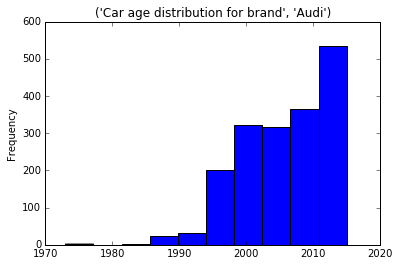

In [368]:
#we import library needed for anlysis
import matplotlib

#Do we have a normal distribution for car age for chosen brand ?
t = 'Car age distribution for brand', brand
#df.sort_values(by='CarAge')
df.CarAge.plot(kind='hist', title=t)

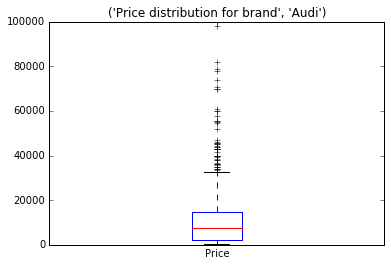

In [369]:
#check for price distribution for chosen brand
t = 'Price distribution for brand', brand
#df.sort_values(by='Price')
df.Price.plot(kind='box', title=t)

In [370]:
#Missing data and outliers

# Check whether there are any missing values.
print('Are there some missing values: ', df.isnull().values.any())

Are there some missing values:  True


In [371]:
# Now check how many rows contain missing values that will be dropped out. We do this only for numeric fields that we need for further calculations.
print('How many rows have missing values for Car age, Price and Milage: ', df.CarAge.isnull().sum().sum(), df.Price.isnull().sum().sum(), df.Milage.isnull().sum().sum())

How many rows have missing values for Car age, Price and Milage:  84 167 83


In [372]:
# Display some of such rows
print('Some such rows: ', df[df.CarAge.isnull()][:2], df[df.Price.isnull()][:2], df[df.Milage.isnull()][:2])

Some such rows:     BrandName  CarAge Engine GearBox  Milage  Price                 Model
2       Audi     nan    NaN     NaN     nan   4200   A3 1.9 TDI Ambiente
14      Audi     nan    NaN     NaN     nan   1250         A8 2.5 TDI V6   BrandName  CarAge                                    Engine  \
0      Audi    2008  diesel motor, 2698 ccm, 132 kW  / 180 KM   
1      Audi    2013  diesel motor, 1968 ccm, 110 kW  / 150 KM   

                GearBox  Milage  Price  \
0  avtomatski menjalnik  324000    nan   
1  avtomatski menjalnik  147500    nan   

                                     Model  
0   A6 2.7 TDI 180ks AUTOMATIC tempomat...  
1   A4 Avant 2.0 TDI Business Multitron...      BrandName  CarAge Engine GearBox  Milage  Price                 Model
2       Audi     nan    NaN     NaN     nan   4200   A3 1.9 TDI Ambiente
14      Audi     nan    NaN     NaN     nan   1250         A8 2.5 TDI V6


In [373]:
#drop missing data but only numeric missing values - when any of them is missing drop row
df = df.dropna(subset=['CarAge','Milage','Price'], how='any')

In [374]:
# The index is not correct now, as we dropped some rows. We have to reset it.
df = df.reset_index(drop=True)

In [375]:
#OUTLIERS
#Outliers can be on all numerical fields. We check price, milage and car age for such outliers and analyze them visualy and numericaly
#numerically we can use function describe to see min and max values, mean and some percentiles
df.describe()


,CarAge,Milage,Price
count,1636,1636,1636
mean,2005,207817,9503
std,6,76057,8957
min,1973,1,290
25%,2000,162240,2350
50%,2006,213000,7325
75%,2011,260000,14500
max,2015,980000,81800


In [376]:
#we could use also df.sort_values(by='CarAge') to se first few records and last few records and used different sorting columns
df.sort_values(by='Price')

,BrandName,CarAge,Engine,GearBox,Milage,Price,Model
387,Audi,1995,"bencinski motor, 1781 ccm, 92 kW / 125 KM",roèni menjalnik (5 pr.),346000,290,A4 1.8
265,Audi,1993,"diesel motor, 2461 ccm, 85 kW / 116 KM",roèni menjalnik (6 pr.),289000,350,100 2.5 TDI 85 KW KLIMA 6 PRESTAV
589,Audi,1998,"bencinski motor, 1595 ccm, 74 kW / 101 KM",roèni menjalnik (5 pr.),280000,350,A4 Avant Cool 1.6
1544,Audi,1986,"diesel motor, 1588 ccm, 37 kW / 50 KM",roèni menjalnik (5 pr.),190000,399,80 CC 1.6 D
841,Audi,1986,"diesel motor, 1588 ccm, 37 kW / 50 KM",roèni menjalnik (5 pr.),190000,399,80 CC 1.6 D
1359,Audi,1986,"diesel motor, 1588 ccm, 37 kW / 50 KM",roèni menjalnik (5 pr.),190000,399,80 CC 1.6 D
1174,Audi,1986,"diesel motor, 1588 ccm, 37 kW / 50 KM",roèni menjalnik (5 pr.),190000,399,80 CC 1.6 D
1248,Audi,1986,"diesel motor, 1588 ccm, 37 kW / 50 KM",roèni menjalnik (5 pr.),190000,399,80 CC 1.6 D
915,Audi,1986,"diesel motor, 1588 ccm, 37 kW / 50 KM",roèni menjalnik (5 pr.),190000,399,80 CC 1.6 D
1581,Audi,1986,"diesel motor, 1588 ccm, 37 kW / 50 KM",roèni menjalnik (5 pr.),190000,399,80 CC 1.6 D


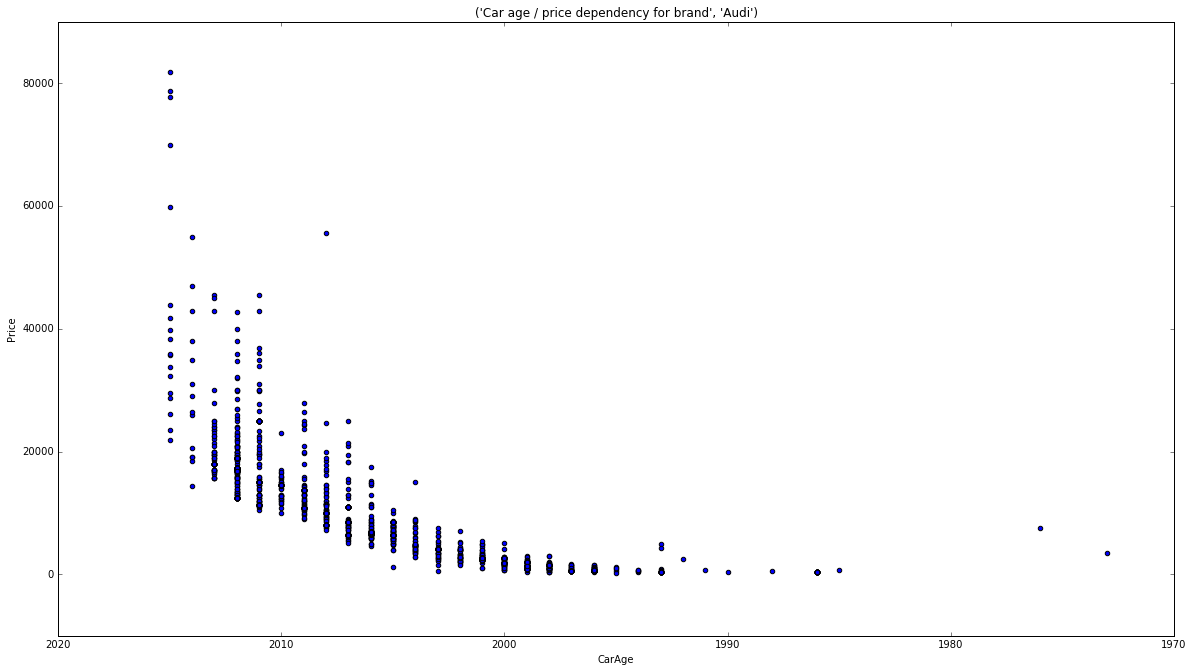

In [377]:
#we also do the graphical representation to see if we missed some marginals
#for price, for milage and for car age
t = 'Car age / price dependency for brand',brand
df.plot.scatter(x='CarAge', y='Price', title=t, figsize=(20,11)).invert_xaxis();

In [378]:
#we remove all cars with price 0 from dataset and all cars that are year 2017 or higher
df = df.loc[(df['Price']!=0)]
df = df.loc[(df['CarAge']<2017)]

In [379]:
# The index is not correct now, as we dropped some rows. We have to reset it.
df = df.reset_index(drop=True)

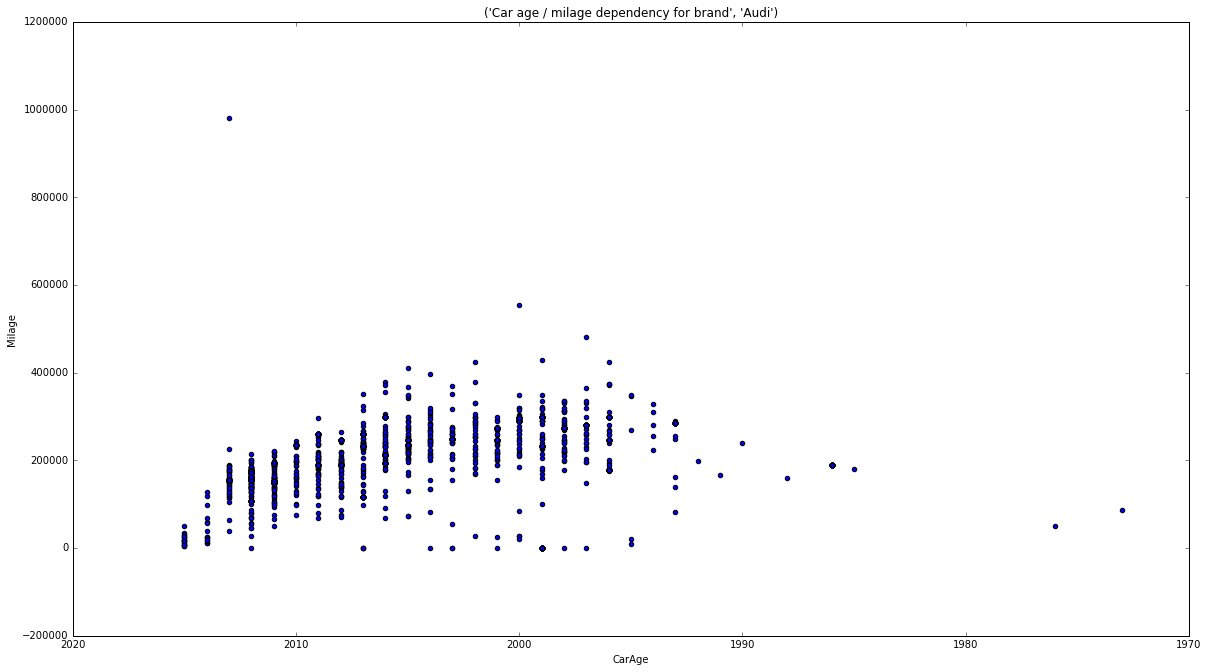

In [380]:
#Check if older cars have more km ? We expect that older cars have more km. But the graph does not show that trend. Hm, maybe some fraud present.
t = 'Car age / milage dependency for brand',brand
df.plot.scatter(x='CarAge', y='Milage', title=t, figsize=(20,11)).invert_xaxis();

In [381]:
#We remove all cars that are one year or older and have less than 10 km but do not remove oldtimers with 0 km (cars older than 1986). They could be engine replaced/renovated.
df = df.loc[((df['Milage']<10) & (df['CarAge']>1986)) != True]

In [382]:
# The index is not correct now, as we dropped some rows. We have to reset it.
df = df.reset_index(drop=True)

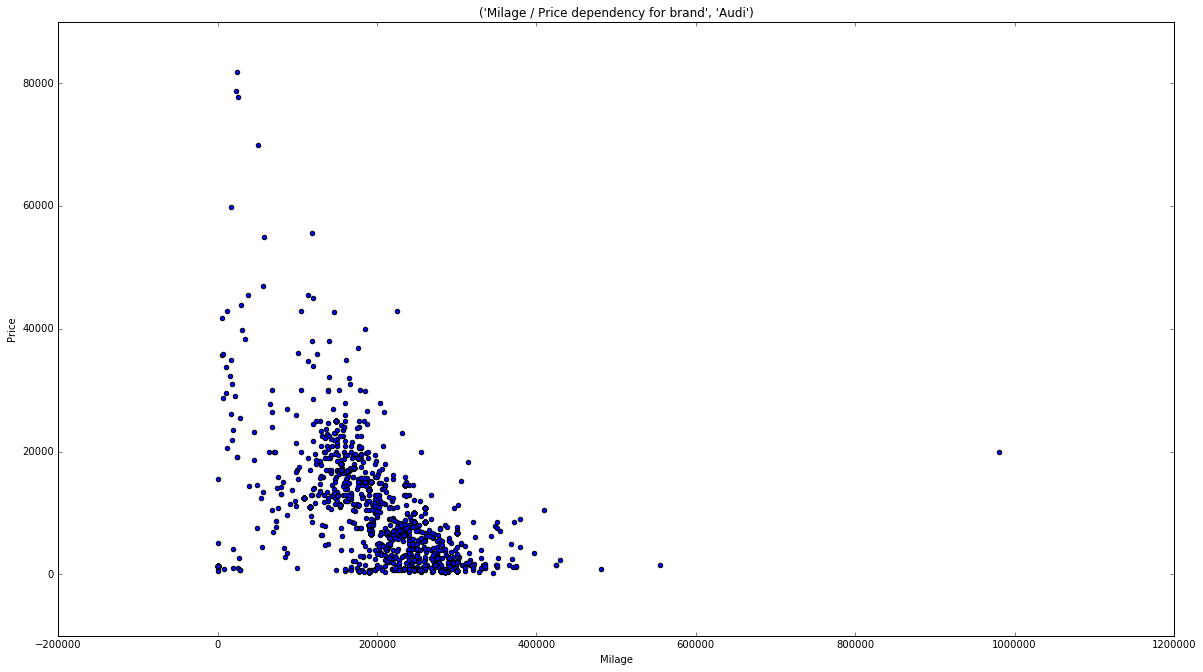

In [383]:
#let's check Price and Milage dependency - for brand
#We expect that price drops for cars with more km
t = 'Milage / Price dependency for brand', brand
df.plot.scatter(x='Milage', y='Price', figsize=(20,11), title=t);

In [384]:
#but still we can see suspicious low km for some cars found. Lets see those cars who did not do more than 5.000km per year
df.loc[(df['Milage']/(2016-df['CarAge']) < 5000 )]

,BrandName,CarAge,Engine,GearBox,Milage,Price,Model
68,Audi,2012,"diesel motor, 1968 ccm, 105 kW / 143 KM",roèni menjalnik (6 pr.),186,15590,A4 Avant 2.0 TDI Business Sport
306,Audi,1976,"bencinski motor, 37 kW / 50 KM",roèni menjalnik (4 pr.),50000,7500,50 50LS
313,Audi,1993,"bencinski motor, 1997 ccm, 103 kW / 140 KM",roèni menjalnik (5 pr.),83000,4350,Coupe 2.0 16V-KLIMA-ABS-EL.IPE-C.Z...
346,Audi,2001,"bencinski motor, 18 ccm, 92 kW / 125 KM",roèni menjalnik (5 pr.),26000,1000,A4 1.8
385,Audi,2003,"bencinski motor, 75 kW / 102 KM",roèni menjalnik (5 pr.),56000,4450,A3 ATTRACTION 1.6
410,Audi,2002,"diesel motor, 1 ccm, 180 kW / 245 KM",roèni menjalnik (6 pr.),27580,2750,A4 Avant quattro 2.5 V6 TDI
421,Audi,1995,"diesel motor, 665 kW / 907 KM",roèni menjalnik (5 pr.),8685,850,80
425,Audi,1973,"bencinski motor, 1300 ccm, 44 kW / 60 KM",roèni menjalnik (4 pr.),87000,3500,80
452,Audi,1995,"bencinski motor + plin, 1781 ccm, 110 kW / 15...",roèni menjalnik (5 pr.),20000,1100,A4 quattro 1.8 T B5
459,Audi,2007,"diesel motor, 2698 ccm, 132 kW / 180 KM",avtomatski menjalnik,21,5100,A4 2.7 V6 TDI DPF


In [385]:
#and remove them from dataset but leave oldtimers
df = df.loc[((df['Milage']/(2016-df['CarAge']) < 5000 ) & (df['CarAge']>1986)) != True]

In [386]:
# The index is not correct now, as we dropped some rows. We have to reset it.
df = df.reset_index(drop=True)

In [387]:
#Now we have done basic data cleaning. We can proceed.
df.describe()

,CarAge,Milage,Price
count,1593,1593,1593
mean,2005,213236,9694
std,6,69395,8990
min,1973,5620,290
25%,2000,168000,2350
50%,2006,215000,7800
75%,2011,260000,14500
max,2015,980000,81800


In [388]:
#In next section we will do analysis for chosen brand model1 and 2

In [389]:
#First we have to extract model name from column Model where some other data is writen
df['Model1'] = df['Model'].str.split(' ').str.get(1) #here the model is only first word - create new column Model1 that contains only model name

In [390]:
#Check for missing values or - in new column Model 1 and remove it:
#df.sort_values(by='Model1')
print('Are there some missing values: ', df.isnull().values.any())

Are there some missing values:  True


In [391]:
#How many rows with missing values in column Model1
print('How many rows have missing values : ', df.Model1.isnull().sum().sum())

How many rows have missing values :  26


In [392]:
#delete rows with missing values
df = df.dropna(subset=['Model1'], how='any')

In [393]:
#delete also rows with Model1 containing character -
df = df.loc[(df['Model1'] != '-')]

In [394]:
# The index is not correct now, as we dropped some rows. We have to reset it.
df = df.reset_index(drop=True)

In [395]:
#what we are interested is:
#Which models and how many models does this brand has ?
print(df.Model1.unique());print('Number of models for brand ',brand,' :',len(df.Model1.unique()))

['A6' 'A4' 'A5' 'A3' 'A8' 'Cabriolet' 'Allroad' 'Q5' 'A7' 'S4' 'Q7' '80'
 'A1' 'TT' 'S8' '100' 'Q3' 'A2' '50' 'R8' 'S5' 'RS4' 'S3' 'SQ5' 'S6']
Number of models for brand  Audi  : 25


In [396]:
#What is the average price for each model
df.pivot_table('Price', columns='Model1', aggfunc='mean')

Model1
100           524
50           7500
80            764
A1          14612
A2           3327
A3           6375
A4           9385
A5          22973
A6           9813
A7          34312
A8          17211
Allroad      8483
Cabriolet    7850
Q3          24774
Q5          23672
Q7          27974
R8          55555
RS4         17500
S3          28245
S4           6990
S5          22224
S6           7000
S8          15200
SQ5         59900
TT          18208
Name: Price, dtype: float64

In [397]:
#which model is mostly sold on market (or we can say also where can customer have biggest choice possibilities)
pd.crosstab(df.BrandName,df.Model1)

Model1,100,50,80,A1,A2,A3,A4,A5,A6,A7,...,Q7,R8,RS4,S3,S4,S5,S6,S8,SQ5,TT
BrandName,,,,,,,,,,,,,,,,,,,,,
Audi,50,1,36,6,3,325,682,51,322,6,...,20,1,1,2,1,2,1,1,1,6


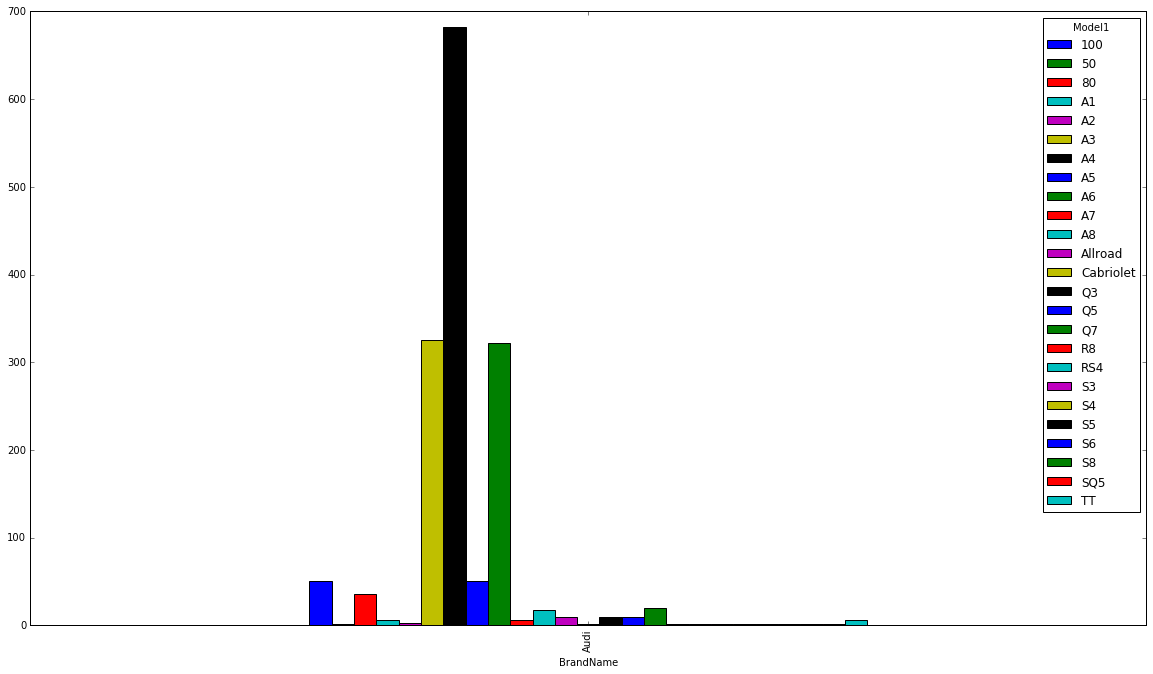

In [398]:
#let's plot it and check visual
pd.crosstab(df.BrandName, df.Model1).plot(kind='bar', figsize=(20,11))

In [399]:
#We will create two new dataframes containing only one model each for all the statistics regarding model comparisons
df_m = df[df.Model1.str.contains(ModelName) == True] 
df_comp = df[df.Model1.str.contains(ModelToCompare) == True] #second model for further comparison (e.g. Peuegot 307, VW Passat)
df_m

,BrandName,CarAge,Engine,GearBox,Milage,Price,Model,Model1
6,Audi,1997,"diesel motor, 1896 ccm, 66 kW / 90 KM",roèni menjalnik (5 pr.),272000,1450,A3 1.9 TDI Attraction,A3
7,Audi,2012,"bencinski motor, 81 kW / 110 KM",roèni menjalnik (6 pr.),57000,13490,A3,A3
17,Audi,2003,"diesel motor, 78 kW / 106 KM",roèni menjalnik (5 pr.),205000,3500,A3,A3
30,Audi,1997,"bencinski motor, 1781 ccm, 92 kW / 125 KM",roèni menjalnik (5 pr.),300000,790,A3 1.8 Ambiente,A3
34,Audi,2014,"diesel motor, 1598 ccm, 77 kW / 105 KM",roèni menjalnik (6 pr.),129000,18450,A3 Sportback 1.6 TDI Ambition.NAVI....,A3
35,Audi,2000,"diesel motor, 1896 ccm, 66 kW / 90 KM",roèni menjalnik (5 pr.),225000,1490,A3 1.9 TDI Attraction,A3
41,Audi,2007,"diesel motor, 1968 ccm, 100 kW / 136 KM",roèni menjalnik (6 pr.),220000,6400,A3 2.0 TDI-6 PRESTAV-ODLIÈEN-17 COL...,A3
79,Audi,2001,"bencinski motor, 1595 ccm, 75 kW / 102 KM",roèni menjalnik (5 pr.),218000,2600,A3 1.6-DIGITALNA KLIMA-15 COL-SLO-S...,A3
80,Audi,2003,"diesel motor, 1896 ccm, 77 kW / 105 KM",roèni menjalnik (5 pr.),243000,4990,A3 1.9 TDI-SLOVENSKI-17 COL-PARKIRN...,A3
81,Audi,2002,"diesel motor, 1998 ccm, 74 kW / 101 KM",roèni menjalnik (5 pr.),287000,3100,A3,A3


In [400]:
#Show the cheapest and most expensive car for one model
df_m.describe()

,CarAge,Milage,Price
count,325,325,325
mean,2005,206523,6375
std,5,63444,4862
min,1996,12000,430
25%,2001,168000,2350
50%,2006,215000,6500
75%,2008,246000,10490
max,2015,336000,34990


In [401]:
#How does price fall with ageing for one model only (e.g.Peugeot 206, VW Golf,...)
s = df_m.pivot_table('Price', columns='CarAge', aggfunc='mean')
s_comp = df_comp.pivot_table('Price', columns='CarAge', aggfunc='mean')
print(s)
print(s_comp)

CarAge
1996     950
1997    1184
1998    1453
1999    1103
2000    1896
2001    2500
2002    3030
2003    3996
2004    5075
2005    5322
2006    6613
2007    6590
2008    8550
2009   11252
2010   12410
2011   11451
2012   12904
2013   16990
2014   22468
2015   22682
Name: Price, dtype: float64
CarAge
1995    1200
1996    1263
1997     617
1998    1604
1999    1987
2000    2462
2001    2432
2002    2264
2003    2981
2004    5617
2005    7867
2006    8034
2007   10453
2008   10748
2009   12299
2010   15261
2011   23787
2012   24183
2013   28980
2014   44970
2015   55200
Name: Price, dtype: float64


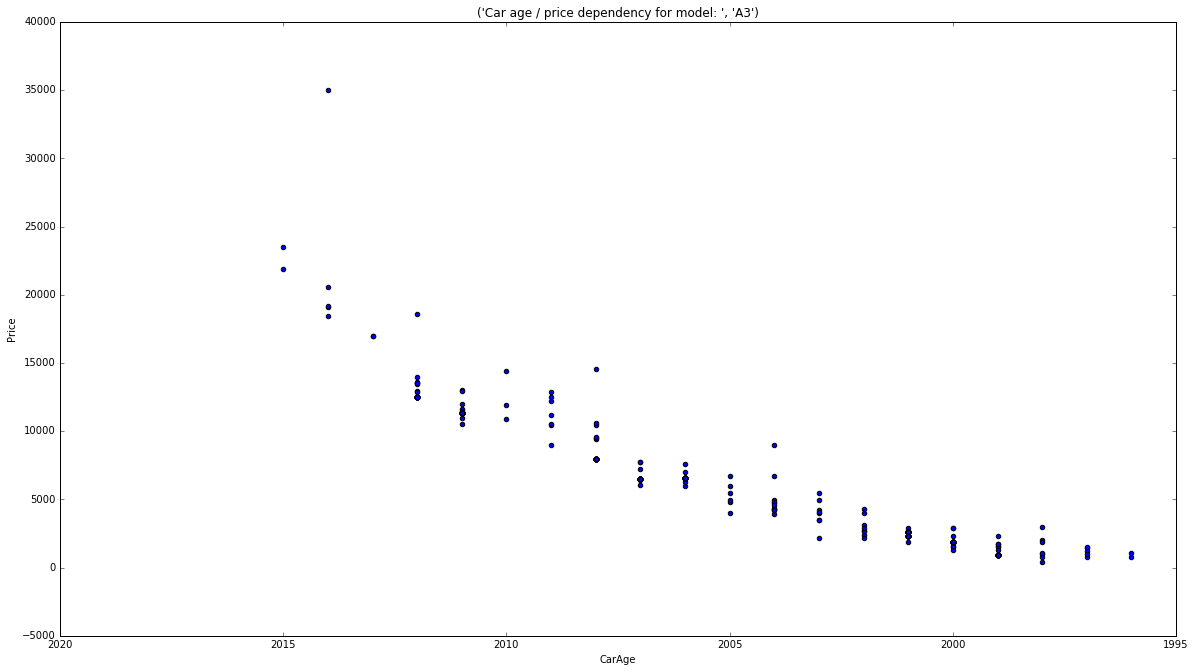

In [402]:
#let's check visually
t = 'Car age / price dependency for model: ',ModelName
df_m.plot.scatter(x='CarAge', y='Price', title=t, figsize=(20,11)).invert_xaxis()

In [403]:
#In which 3 year period two of compared models looses less value ?
#lets calculate what is the average price drop for first 3 years for this two models
FirstYear = s.values[-1]-s.values[-2]
FirstYearC = s_comp.values[-1]-s_comp.values[-2]
SecondYear = s.values[-2] - s.values[-3]
SecondYearC = s_comp.values[-2] - s_comp.values[-3]
ThirdYear = s.values[-3] - s.values[-4]
ThirdYearC = s_comp.values[-3] - s_comp.values[-4]

print('Price drop for the first 3 years for model',ModelName,'is:', FirstYear+SecondYear+ThirdYear,'EUR on average')
print('Price drop for the first 3 years for model',ModelToCompare,'is:', FirstYearC+SecondYearC+ThirdYearC,'EUR on average')

Price drop for the first 3 years for model A3 is: 9778.0483871 EUR on average
Price drop for the first 3 years for model A6 is: 31016.7692308 EUR on average


In [404]:
#and for each year separatelly
print(ModelName)
print('In 1. year from',s.values[-1],'EUR average to',s.values[-2],'EUR average in total:',FirstYear,'EUR drop', 100*FirstYear/s.values[-1],'%')
print('In 2. year from',s.values[-2],'EUR average to',s.values[-3],'EUR average in total:',SecondYear,'EUR drop', 100*SecondYear/s.values[-2],'%')
print('In 3. year from',s.values[-3],'EUR average to',s.values[-4],'EUR average in total:',ThirdYear,'EUR drop', 100*ThirdYear/s.values[-3],'%')
print(ModelToCompare)
print('In 1. year from',s_comp.values[-1],'EUR average to',s_comp.values[-2],'EUR average in total:',FirstYearC,'EUR drop', 100*FirstYearC/s_comp.values[-1],'%')
print('In 2. year from',s_comp.values[-2],'EUR average to',s_comp.values[-3],'EUR average in total:',SecondYearC,'EUR drop', 100*SecondYearC/s_comp.values[-2],'%')
print('In 3. year from',s_comp.values[-3],'EUR average to',s_comp.values[-4],'EUR average in total:',ThirdYearC,'EUR drop', 100*ThirdYearC/s_comp.values[-3],'%')

A3
In 1. year from 22682.5 EUR average to 22467.8 EUR average in total: 214.7 EUR drop 0.946544693045 %
In 2. year from 22467.8 EUR average to 16990.0 EUR average in total: 5477.8 EUR drop 24.3806692244 %
In 3. year from 16990.0 EUR average to 12904.4516129 EUR average in total: 4085.5483871 EUR drop 24.0467827375 %
A6
In 1. year from 55200.0 EUR average to 44970.0 EUR average in total: 10230.0 EUR drop 18.5326086957 %
In 2. year from 44970.0 EUR average to 28979.8888889 EUR average in total: 15990.1111111 EUR drop 35.5572851036 %
In 3. year from 28979.8888889 EUR average to 24183.2307692 EUR average in total: 4796.65811966 EUR drop 16.5516787799 %


In [405]:
#For customers is good to know which year of car is most present on the market - for chosen model
pd.crosstab(df_m.Model1, df_m.CarAge)

CarAge,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0
Model1,,,,,,,,,,,,,,,,,,,,
A3,2,5,7,29,30,51,8,8,11,6,28,30,29,7,3,31,31,2,5,2


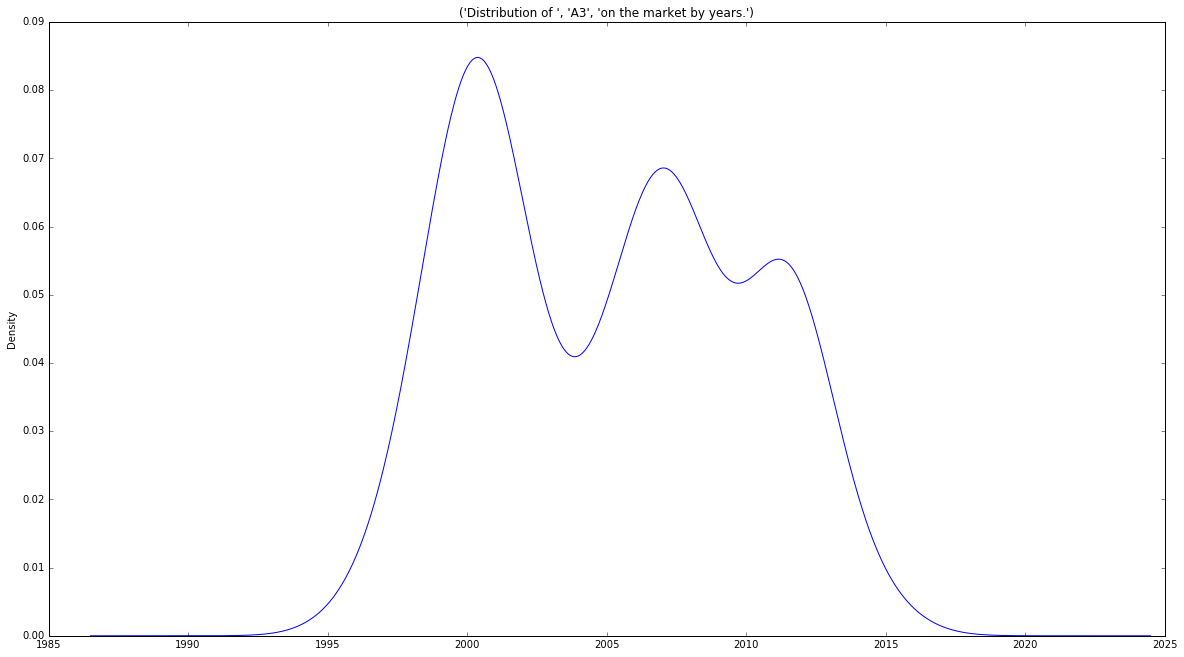

In [406]:
#and do the visuals again to see years of model that is most selling on the market or How high is the loyalty of model.
title = 'Distribution of ', ModelName, 'on the market by years.'
df_m.CarAge.plot(kind='kde', title=title, figsize=(20,11))


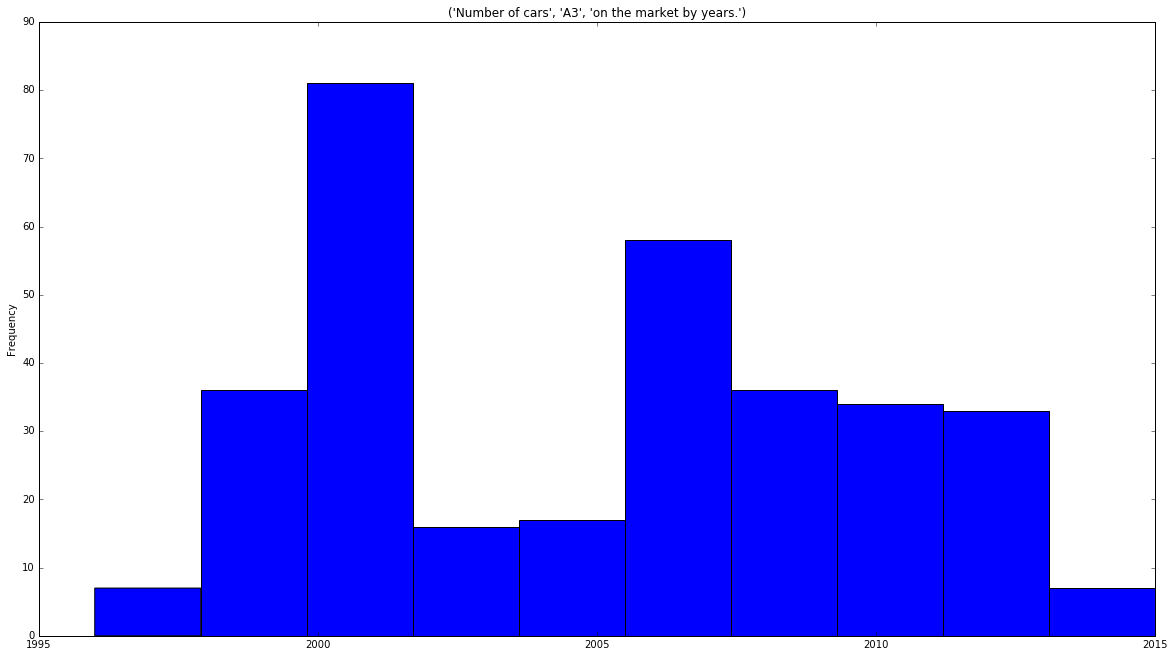

In [407]:
title = 'Number of cars', ModelName, 'on the market by years.'
df_m.CarAge.plot(kind='hist', title=title, figsize=(20,11))

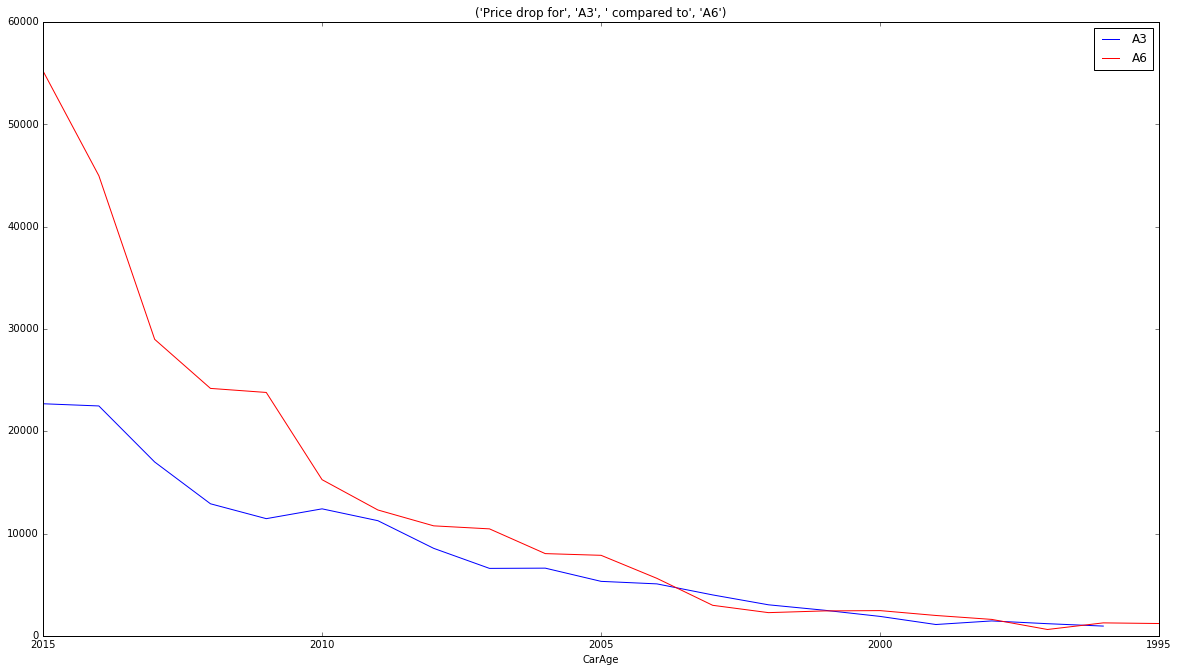

In [408]:
#We would like to see which model looses on value faster comparing two different model the same brand - visualize from graph below
#compare mean price per year for model1 and model2
t = 'Price drop for', ModelName,' compared to', ModelToCompare
df_m.pivot_table('Price', columns='CarAge', aggfunc='mean').plot(figsize=(20,11), color='blue').invert_xaxis()
df_comp.pivot_table('Price', columns='CarAge', aggfunc='mean').plot(title=t, figsize=(20,11), color='red').invert_xaxis()
legend([ModelName,ModelToCompare])

In [427]:
#from which point in time further on the price of car (for model 1 and model 2) drops to almost the same level?
#first line intersection
x = df_m.pivot_table('Price', columns='CarAge', aggfunc='mean')
y = df_comp.pivot_table('Price', columns='CarAge', aggfunc='mean')
#we have to adjust curve length to be equal size for both models to do the calculations
if len(x) > len(y):
    x = x.iloc[(len(x)-len(y)):]
else:
    y = y.iloc[(len(y)-len(x)):]

#compare values of x and y year by year and where equality sign changes there is the first occurance
n=1
if x.iloc[len(x)-1] > (y.iloc[len(y)-1]):
    for i in range(len(x)):
        if x.iloc[len(x)-1-i] < y.iloc[len(y)-1-i]:
            print(n,'. they meet in',x.index[len(x)-1-i],'at avg. price of model',ModelName,'',x.iloc[len(x)-1-i],'EUR and avg. price of model',ModelToCompare,'',y.iloc[len(y)-1-i])
            n+=1
else:
    for i in range(len(x)):
        if x.iloc[len(x)-1-i] > y.iloc[len(y)-1-i]:
            print(n,'. they meet in',x.index[len(x)-1-i],'at avg. price of model',ModelName,'',x.iloc[len(x)-1-i],'EUR and avg. price of model',ModelToCompare,'',y.iloc[len(y)-1-i])
            n+=1

1 . they meet in 2003.0 at avg. price of model A3  3996.25 EUR and avg. price of model A6  2980.66666667
2 . they meet in 2002.0 at avg. price of model A3  3030.0 EUR and avg. price of model A6  2264.14285714
3 . they meet in 2001.0 at avg. price of model A3  2500.37254902 EUR and avg. price of model A6  2432.25
4 . they meet in 1997.0 at avg. price of model A3  1184.0 EUR and avg. price of model A6  617.307692308


In [429]:
#from wich point in time the price difference between two models is lower than a let say 10% of a new car
p = 0.10 #percent drop compared to new car price of model 1
x = df_m.pivot_table('Price', columns='CarAge', aggfunc='mean')
y = df_comp.pivot_table('Price', columns='CarAge', aggfunc='mean')

#we have to adjust curve length to be equal size for both models to do the calculations
if len(x) > len(y):
    x = x.iloc[(len(x)-len(y)):]
else:
    y = y.iloc[(len(y)-len(x)):]

#compare values of x and y year by year and where equality sign changes or difference between avg prices is smaller than diff print the point and exit
if x.iloc[len(x)-1] > (y.iloc[len(y)-1]):
    diff = x.iloc[len(x)-1]*p #calculate diff as a % of value of new car
    for i in range(len(x)):
        if (x.iloc[len(x)-1-i] - (y.iloc[len(y)-1-i])) < diff:
            print('They get close to price difference smaller than',diff,'in year',x.index[len(x)-1-i],'at avg. price of model',ModelName,'',x.iloc[len(x)-1-i],'EUR and avg. price of model',ModelToCompare,'',y.iloc[len(y)-1-i])
            break
else:
    diff = y.iloc[len(y)-1]*p #calculate diff as a % of value of new car
    for i in range(len(x)):
        if ((y.iloc[len(y)-1-i] - x.iloc[len(x)-1-i])) < diff:
            print('They get close to price difference smaller than',diff,'in year',x.index[len(x)-1-i],'at avg. price of model',ModelName,'',x.iloc[len(x)-1-i],'EUR and avg. price of model',ModelToCompare,'',y.iloc[len(y)-1-i])
            break

They get close to price difference smaller than 5520.0 in year 2010.0 at avg. price of model A3  12410.0 EUR and avg. price of model A6  15260.8333333


In [411]:
#calculate max price difference for model of the same age for all years found
df_m_min = df_m.pivot_table('Price', columns='CarAge', aggfunc=min)
df_comp_min = df_comp.pivot_table('Price', columns='CarAge', aggfunc=min)
df_m_max = df_m.pivot_table('Price', columns='CarAge', aggfunc=max)
df_comp_max = df_comp.pivot_table('Price', columns='CarAge', aggfunc=max)

df_m_change = df_m_max-df_m_min

#df_m_change.index[1]
print('The year of model ',ModelName,' with biggest price difference is : \n', df_m_change[df_m_change == df_m_change.max()].index[0])
print('The difference in price between cheapest and most expensive ',ModelName,' for this year is: ', df_m_change.max(),' EUR')

The year of model  A3  with biggest price difference is : 
 2014.0
The difference in price between cheapest and most expensive  A3  for this year is:  16540.0  EUR


In [412]:
#Let's look at all cars in this year to see the differences
df_my = df_m[df_m.CarAge == df_m_change[df_m_change == df_m_change.max()].index[0]].sort_values(by='Price')
df_my

,BrandName,CarAge,Engine,GearBox,Milage,Price,Model,Model1
34,Audi,2014,"diesel motor, 1598 ccm, 77 kW / 105 KM",roèni menjalnik (6 pr.),129000,18450,A3 Sportback 1.6 TDI Ambition.NAVI....,A3
407,Audi,2014,"bencinski motor, 1197 ccm, 77 kW / 105 KM",roèni menjalnik (6 pr.),24900,19100,A3 1.2 TFSI Attraction 1. lastnik S...,A3
516,Audi,2014,"bencinski motor, 1197 ccm, 77 kW / 105 KM",roèni menjalnik (6 pr.),24900,19200,A3 1.2 TFSI Attraction,A3
488,Audi,2014,"diesel motor, 1598 ccm, 81 kW / 110 KM",roèni menjalnik (6 pr.),12000,20599,A3 Sportback 1.6 TDI diesel Ambien...,A3
609,Audi,2014,"diesel motor, 1968 ccm, 135 kW / 184 KM",avtomatski menjalnik,16500,34990,A3 Sportback quattro 2.0 TDI clean ...,A3


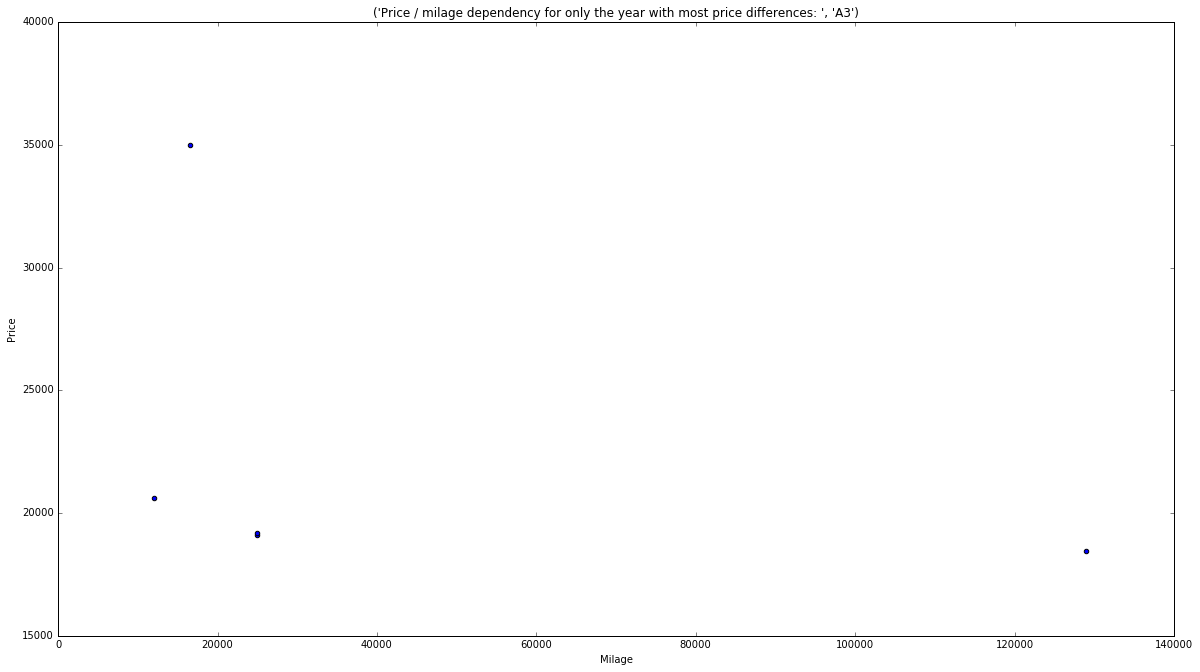

In [413]:
#lets plot for this year milage price dependency - do we have maybe an outlier here ?
t = 'Price / milage dependency for only the year with most price differences: ',ModelName
df_my.plot.scatter(x='Milage', y='Price', title=t, figsize=(20,11))

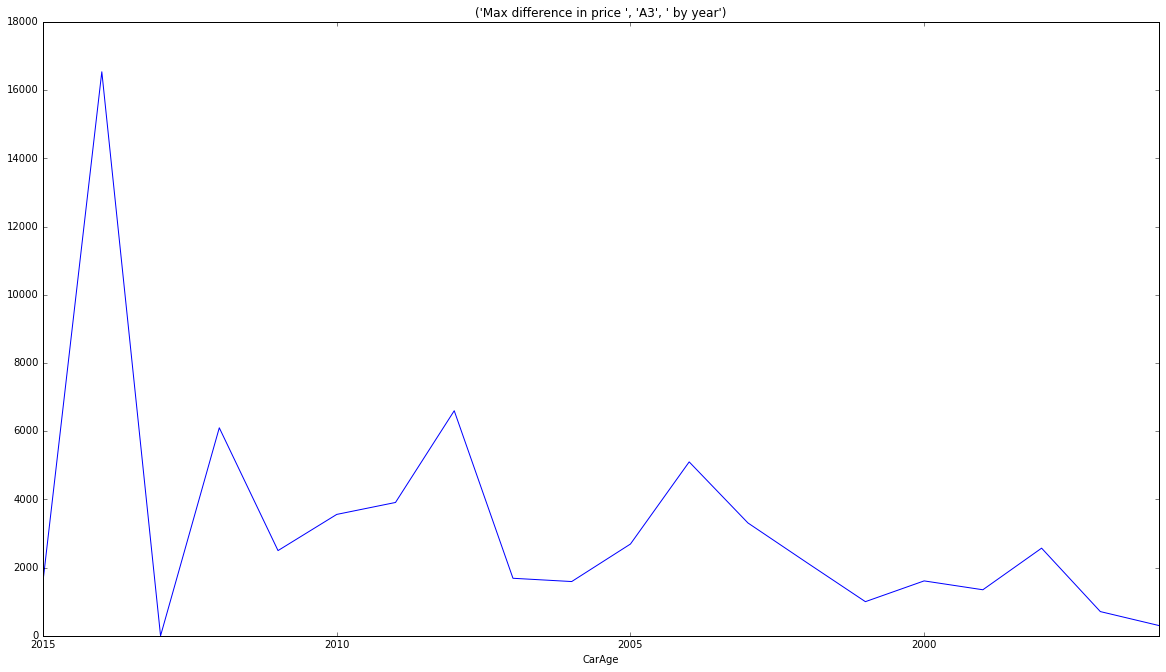

In [414]:
#let's visualize max price difference for model for every year
t = 'Max difference in price ', ModelName,  ' by year'
df_m_change.plot(title=t, figsize=(20,11)).invert_xaxis()

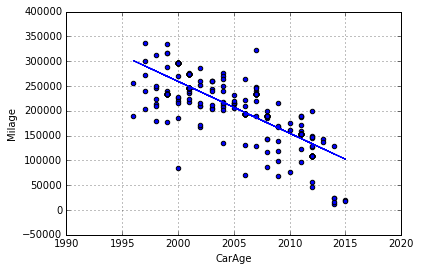

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Milage   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     550.6
Date:                Fri, 22 Apr 2016   Prob (F-statistic):           9.19e-72
Time:                        00:56:52   Log-Likelihood:                -3892.8
No. Observations:                 325   AIC:                             7790.
Df Residuals:                     323   BIC:                             7797.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.118e+07   8.94e+05     23.695      0.000      1.94e+07  2.29e+07
CarAge     -1.046e+04    445.763    -23.464      0.000     -1.13e+04 -9582.493
==============================================================================
Omnibus:                       43.243   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.535
Skew:                          -0.803   Prob(JB):                     7.95e-16
Kurtosis:                       4.599   Cond. No.                     8.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [431]:
#lets finish here with main hipotheses testing, now that we have all the data 
#Cars with better Brandname perception have less price drop in first 3 years
#We have compared model 1 to model 2 with brand perception registered from Tweets

# this is the standard import if you're using "formula notation" (similar to R)
import statsmodels.formula.api as smf

x=df_m['CarAge']
y=df_m['Milage']

(m,b) = polyfit(x,y,1)

yp = polyval([m,b],x)
plot(x,yp)
scatter(x,y)
grid(True)

xlabel('CarAge')
ylabel('Milage')

show()

# create a fitted model in one line
lm = smf.ols(formula='Milage ~ CarAge', data=df_m).fit()
lm.summary()
